# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Добейтесь значения MAE на тестовой выборке не больше 8.

**Цель проекта**

Построить и обучить свёрточную нейронную сеть определению возраста покупателей по фотографии покупателей для составления рекомендаций товаров по каждой возрастной группе и контроля продажи алкоголя несовершеннолетним.

**План работы**
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

**Описание данных**

Данные находятся в папке `/datasets/faces/`, в которой находятся одна папка со всеми изображениями `final_files` и CSV-файл `labels.csv` с двумя колонками: 

- `'file_name'` — имя изображения, 
- `'real_age'` — возраст покупателя.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Создание-функций" data-toc-modified-id="Создание-функций-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Создание функций</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Построение-графика" data-toc-modified-id="Построение-графика-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Построение графика</a></span></li><li><span><a href="#Изучение-изображений" data-toc-modified-id="Изучение-изображений-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Изучение изображений</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Загрузка

### Импорт библиотек

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, 
    Dense, 
    Flatten
)

In [2]:
# Фиксируем RANDOM_STATE
RS = 54321

### Создание функций

In [3]:
# Функция для предварительного изучения 
# общей информации о данных.  
def data_research(dataset):
    
    
    # Отображение 5 первых и последних строк.
    display(dataset.head())
    display(dataset.tail())
    print()
    
    
    # Отображение информации о данных.
    display(HTML('<h3>Общая информация о данных</h3><br>'))
    print(dataset.info())
    
    
    # Отображение списка наименования столбцов.
    display(HTML('<h3>Наименования столбцов</h3><br>'))
    print(dataset.columns)
 

    # Проверка на пропуски и их изучение.
    display(HTML('<br><h3>Количество и доля пропущенных значений</h3><br>'))
    
    if dataset.isna().sum().any():

        display(HTML(
            f'<b>Количество пропусков во всем датафрейме: </b>'\
            f'{dataset.isna().sum().sum()} '\
            f'({round((dataset.isna().sum().sum() / (dataset.shape[0] * dataset.shape[1]) * 100), 1)}%)<br>')
               )
        
        display(HTML(
            f'<b>Записи, имеющие хотя бы один пропуск: </b>'\
            f'{dataset[dataset.columns].isna().any(axis=1).sum()} '\
            f'({round((dataset[dataset.columns].isna().any(axis=1).sum() / dataset.shape[0] * 100), 1)}%)<br>')
               )
               
        display(HTML('<b>Количество пропусков в каждом столбце: </b>'))
        display(pd.DataFrame({
            'count': dataset.isna().sum(),
            '%': dataset.isna().mean() * 100
            }).style.set_precision(1).background_gradient('coolwarm'))
    
    else:
        print('Пропуски отсутствуют')
    
    
    # Проверка на явные дубликаты.
    display(HTML('<br><h3>Количество дубликатов в датафрейме</h3><br>'))
    
    if dataset.duplicated().sum() != 0:

        print(f'Всего: {dataset.duplicated().sum()} '
              f'({(dataset.duplicated().sum() / dataset.shape[0]):.2%} '\
              f'от общего размера)')
        
    else:
        print('Явные дубликаты отсутствуют')
    

    # Проверка уникальных значений признаков.
    display(HTML('<br><h3>Уникальные значения в датафрейме</h3><br>'))    
        
    for column in dataset.columns:
        display(HTML(f'<b>Уникальные значения в столбце "{column}": </b>'\
                     f'{len(dataset[column].unique())}'))
            
        print(dataset.sort_values(by=column)[column].unique())
   

    # Изучение информации о количественных данных.
    display(HTML('<br><h3>Описание данных</h3>'))
    display(dataset.describe().transpose())

In [4]:
# Функция для построения графиков для количественных признаков.  
def int_plot(data, column):
    
    
    # Создаем фигуру с двумя подграфиками.  
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    
    # Строим график.  
    sns.histplot(data=data, 
                 x=column, 
                 ax=axs[0], 
                 kde=True,
                 bins=99)
    axs[0].grid(True)
    axs[0].set_xlabel('Возраст')
    axs[0].set_ylabel('Количество записей')
    
    
    # Строим диаграмму размаха.  
    sns.boxplot(data=data, x=column, ax=axs[1])
    axs[1].grid(True)
    axs[1].set_xlabel('Возраст')
    
    
    plt.suptitle(f'График распределения и '\
                 f'диаграмма размаха возраста покупателей')
    plt.tight_layout()
    plt.show()

In [5]:
# Функция для вывода изображений на экран
def show_images(df):
    num_images = len(df)
    # Вычисляем количество строк, округляя вверх
    num_rows = (num_images + 2) // 3
    fig, axes = plt.subplots(
        num_rows, 
        3, 
        figsize=(15, 5 * num_rows)
    )
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(df.iterrows()):
        image = Image.open(path + row['file_name'])
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"\nВозраст: {row['real_age']}"
                          f"\n{row['file_name']}")

    # Удаляем пустые графики, если 
    # количество изображений не кратно 3.
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Загрузка данных 

In [6]:
path = '/datasets/faces/final_files/'

In [7]:
data = pd.read_csv('/datasets/faces/labels.csv')

[Вернуться к содержанию](#Содержание)

## Исследовательский анализ данных

### Изучение данных 

In [8]:
data_research(data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Index(['file_name', 'real_age'], dtype='object')


Пропуски отсутствуют


Явные дубликаты отсутствуют


['000000.jpg' '000001.jpg' '000002.jpg' ... '007610.jpg' '007611.jpg'
 '007612.jpg']


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  94  95  96  97 100]


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Данные загружены, они соответствуют описанию задачи. Пропуски и явные дубликаты отсутствуют, данные не требуют проведения предобработки.

Всего у нас представлено 7591 данных с фото и возрастом покупателей от 1 года до 100 лет. Данных должно быть достаточно для обучения модели распознавания возраста.

### Построение графика

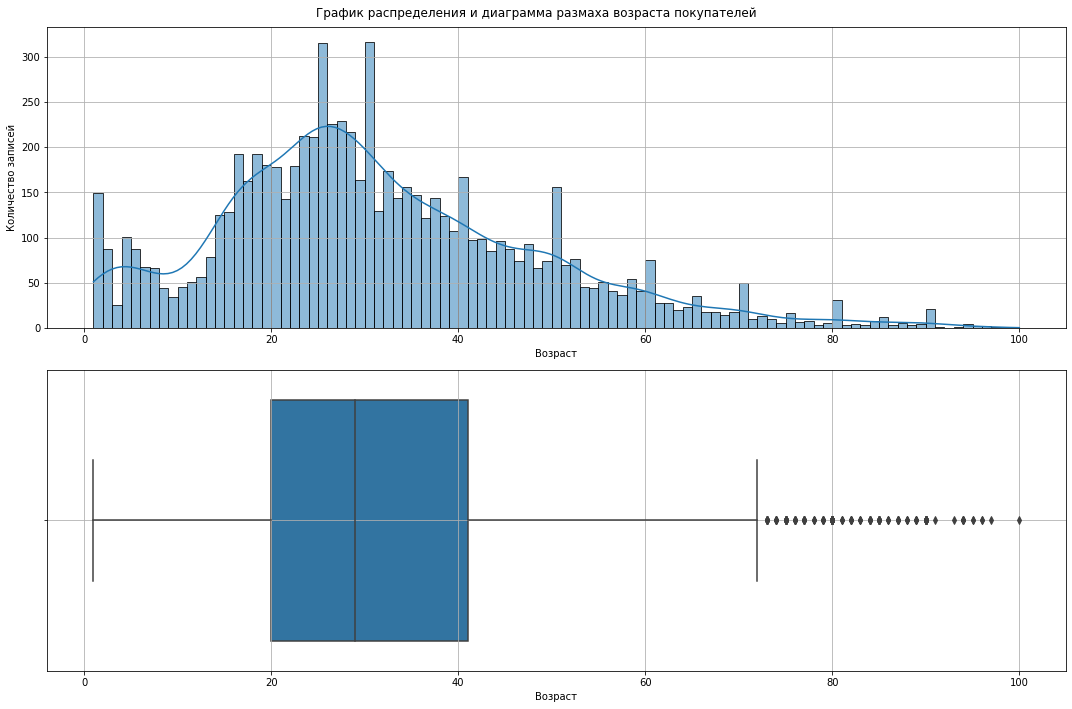

In [9]:
int_plot(data, 'real_age')

График имеет бимодальный характер со смещением влево, распределение нормальное. Пик значений приходится на диапазон 23-30 лет, также имеется небольшой всплеск ближе к нулю.

На графике видны выделяющиеся пики в 25, 30, 40, 50, 60, 70, 80 и 90 лет. Вероятнее всего, это связано с указанием округленного возраста.

Средний возраст покупателя - 31 год, медианный - 29, что говорит о смещении распределения в сторону младшего возраста. Возраст старше 66 лет отмечается как аномальный, т.к. данных по ним гораздо меньше. Модель будет иметь меньшую точность в этом диапазоне.

Проверим на корректность возраста фотографии покупателей младше 3 лет и старше 90 лет.

### Изучение изображений

Проверим на корректность возраста фотографии покупателей младше 3 лет и старше 90 лет. 

Также выведем несколько фотографий людей среднего возраста.

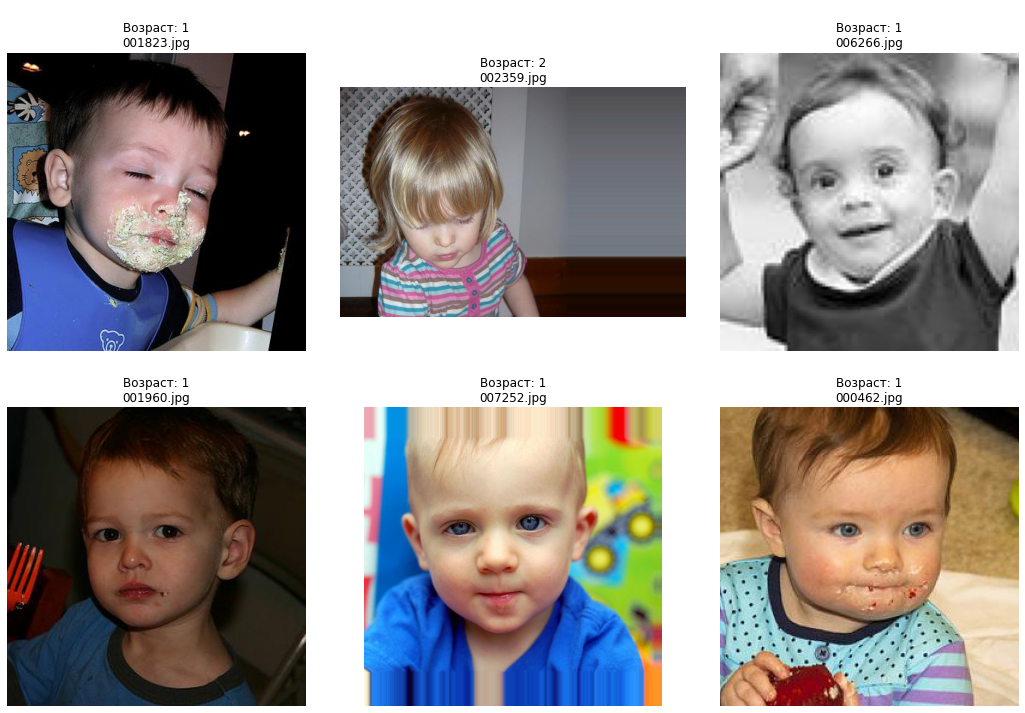

In [10]:
show_images(
    data[data['real_age'] <= 3]
    .sample(
        6, 
        random_state = RS
))

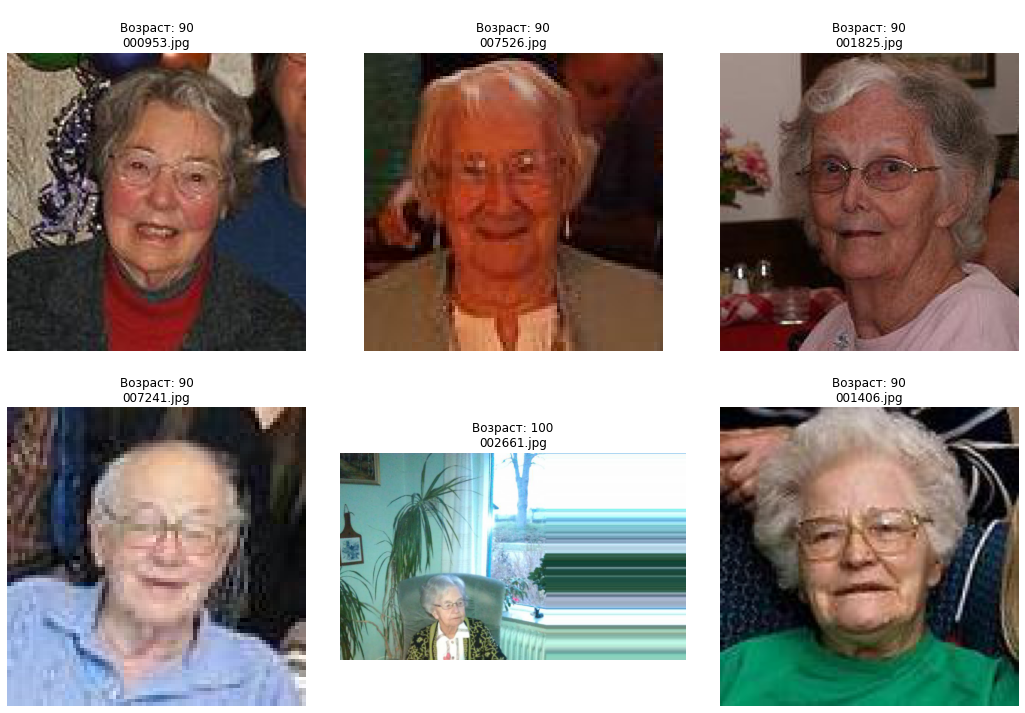

In [11]:
show_images(
    data[data['real_age'] >= 90]
    .sample(
        6, 
        random_state = RS
))

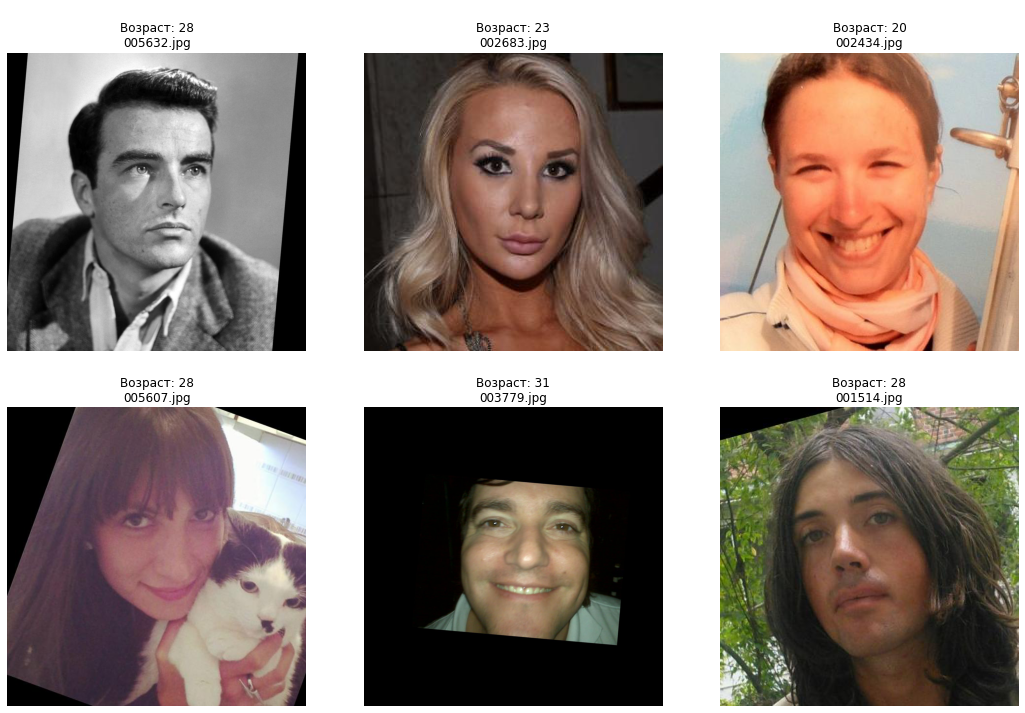

In [12]:
show_images(
    data.query('20 <= real_age <= 50')
    .sample(
        6, 
        random_state = RS
))

Фотографии соответствуют указанному возрасту в данных, ошибок не наблюдается. 

Датасет содержит различного качества фотографии людей разного возраста и пола, выполненных в разных условиях освещения, с разных ракурсов и с разным фоном. Можно заметить, что фотографии ранее были обработаны таким образом, что положение лица выровнено вертикально и занимает большую часть изображения.

Некоторые фотографии имеют прямоугольный формат. Также встречаются черно-белые фотографии. Часть фотографий содержат артефакты в виде черного фона, оставшегося после поворота лиц. Также на некоторых изображениях можно заметить "растянутые" пиксели. На некоторых фото лицо не показано крупным планом.

[Вернуться к содержанию](#Содержание)

## Обучение модели

Построим свёрточную нейронную сеть `ResNet50`, предобученной на наборе изображений. Добавим горизонтальное отражение изображений для повышения общей устойчивости модели. В качестве основы используем слой `GlobalAveragePooling2D`, а также полносвязный слой с одним выходом и функцией активации `ReLU`. Размер батча - 16 изображений, значение lr - 0.0001, количество эпох - 7.

Для этого в коде мы используем следующие функции:
- `load_train` - загрузка обучающей выборки,
- `load_test` - загрузка тестовой выборки,
- `create_model` - создание нейронной сети,
- `train_model` - тренировка и запуск модели.

В качестве метрики качества будем использовать MAE, функция потерь - MSE.

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu')) 
    model.compile(
        optimizer=optimizer, 
        loss='mse', 
        metrics=['mae']
    ) 
    
    return model


def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=7,
    steps_per_epoch=None, 
    validation_steps=None
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)  
       
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
  
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/7
356/356 - 91s - loss: 213.4559 - mae: 10.4857 - val_loss: 763.4284 - val_mae: 22.6967
Epoch 2/7
356/356 - 55s - loss: 85.6785 - mae: 7.0678 - val_loss: 157.3943 - val_mae: 9.3738
Epoch 3/7
356/356 - 59s - loss: 59.2020 - mae: 5.8531 - val_loss: 111.9151 - val_mae: 7.9055
Epoch 4/7
356/356 - 56s - loss: 43.3227 - mae: 5.0360 - val_loss: 78.7453 - val_mae: 6.6685
Epoch 5/7
356/356 - 57s - loss: 32.2671 - mae: 4.3696 - val_loss: 99.9724 - val_mae: 7.4542
Epoch 6/7
356/356 - 70s - loss: 24.3995 - mae: 3.7869 - val_loss: 80.4340 - val_mae: 6.6235
Epoch 7/7
356/356 - 70s - loss: 20.6308 - mae: 3.4378 - val_loss: 72.6530 - val_mae: 6.1974

119/119 - 13s - loss: 72.6530 - mae: 6.1974
Test MAE: 6.1974

```

[Вернуться к содержанию](#Содержание)

## Анализ обученной модели

Средняя абсолютная ошибка (MAE) показала, что в определении возраста модель ошибается в среднем на 6.2 лет, что ниже установленного порога в 8 - модель демонстрирует достаточно высокую точность.

Перед внедрением модели в работу рекомендуется провести тестирование модели на реальных данных из магазина, чтобы убедиться в её применимости в условиях реальной эксплуатации. Это поможет выявить возможные проблемы и провести доработку модели перед полномасштабным внедрением.

Модель рекомендуется в определении возрастных групп клиентов для анализа покупок для составления рекомендаций товаров, но ее точности может быть недостаточно для контролирования продажи алкоголя несовершеннолетним, т.к. погрешность в 6 лет для этой цели - довольно большая.

Во втором случае модель может быть полезным инструментом, но её стоит рассматривать как часть комплексной системы контроля, а не единственный метод.

[Вернуться к содержанию](#Содержание)